<a href="https://colab.research.google.com/github/BrajanNieto/stats-prob-py/blob/main/98.%20PilotoAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
import io
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import svd
from scipy import stats

Importar Datos

In [19]:
# 1. Sube el archivo
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"Archivo subido: {file_name}")
df_encuesta = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='PRE TEST', skiprows = 1)


df_encuesta.head()

Saving PRUEBA PILOTO TOTAL AM.xlsx to PRUEBA PILOTO TOTAL AM (3).xlsx
Saving ANGELA BAUTISTA VALIDACION.pdf to ANGELA BAUTISTA VALIDACION.pdf
Saving INSTRUMENTOS FINAL  (3)adulto mayor.pdf to INSTRUMENTOS FINAL  (3)adulto mayor (1).pdf
Saving PRUEBA PILOTO TOTAL AM (1).xlsx to PRUEBA PILOTO TOTAL AM (1) (1).xlsx
Archivo subido: PRUEBA PILOTO TOTAL AM (3).xlsx


,CODIGO,NOMBRES Y APELLIDOS,ZONA,D1,D2,D3,D4,D5,D6,D7,...,I3-2,I3-3,I3-4,I3-5,I3-6,I3-7,I3-8,I3-TOTAL,I3-CLASE,IMT
0,P1,AMBROSIA ELENA MAYTA DE COAQUERA,NORTE,0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,2.0,2.0,2.0,1.0,2.0,17,FUTURAS EVALUACIONES,4
1,P2,MARTIN CONDORI MAMANI,NORTE,0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,2.0,1.0,3.0,2.0,2.0,14,FUTURAS EVALUACIONES,5
2,P3,SATURNINO MOLLINEDO GOMEZ,NORTE,0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,1.0,0.0,1.0,0.0,0.0,8,DETERIORO,2
3,P4,VICTORIANO QUISPE TINTAYA,NORTE,0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,0.0,1.0,11,DETERIORO,3
4,P5,MERCEDES CALLO CALLO,NORTE,0,0.0,0.0,0.0,0.0,1.0,1.0,...,2.0,2.0,2.0,1.0,1.0,0.0,0.0,11,DETERIORO,3


# Análisis del Piloto

In [20]:
df_piloto = df_encuesta[df_encuesta['CODIGO'].notna()]

print("Descripción estadística de df_piloto:")
print(df_piloto.describe(include='all'))

Descripción estadística de df_piloto:
       CODIGO              NOMBRES Y APELLIDOS     ZONA    D1         D2  \
count      30                                30      30  30.0  30.000000   
unique     30                                30       3   2.0        NaN   
top        P1  AMBROSIA ELENA MAYTA DE COAQUERA  CENTRO   0.0        NaN   
freq        1                                 1      14  20.0        NaN   
mean      NaN                               NaN     NaN   NaN   0.300000   
std       NaN                               NaN     NaN   NaN   0.466092   
min       NaN                               NaN     NaN   NaN   0.000000   
25%       NaN                               NaN     NaN   NaN   0.000000   
50%       NaN                               NaN     NaN   NaN   0.000000   
75%       NaN                               NaN     NaN   NaN   1.000000   
max       NaN                               NaN     NaN   NaN   1.000000   

               D3         D4         D5         D

In [21]:
print("\nNulos por columna en df_piloto:")
print(df_piloto.isnull().sum())


Nulos por columna en df_piloto:
CODIGO                  0
NOMBRES Y APELLIDOS     0
ZONA                    0
D1                      0
D2                      0
D3                      0
D4                      0
D5                      0
D6                      0
D7                      0
D8                      0
D9                      0
D10                     0
DTOTAL                  0
DCLASE                  0
I1-1                    0
I1-2                    0
I1-3                    0
I1-4                    0
I1-5                    0
I1-6                    0
I1-7                    0
I1-8                    0
I1-9                    0
I1-10                   0
I1-Total                0
I1-CLASE                0
I2-1                    0
I2-2                    0
I2-3                    0
I2-4                    0
I2-5                    0
I2-6                    0
I2-7                    0
I2-8                    0
I2-9                    0
I2-10                   0
I2-TO

In [22]:
print("\nColumnas de df_piloto:")
print(", ".join(df_piloto.columns))


Columnas de df_piloto:
CODIGO, NOMBRES Y APELLIDOS , ZONA, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, DTOTAL, DCLASE, I1-1, I1-2, I1-3, I1-4, I1-5, I1-6, I1-7, I1-8, I1-9, I1-10, I1-Total, I1-CLASE, I2-1, I2-2, I2-3, I2-4, I2-5, I2-6, I2-7, I2-8, I2-9, I2-10, I2-TOTAL, I2-CLASE, I3-1, I3-2, I3-3, I3-4, I3-5, I3-6, I3-7, I3-8, I3-TOTAL, I3-CLASE, IMT


## Validación del Constructo

### Bartlett

In [15]:
# ─────────────────────────────────────────────
# 1.  Test de esfericidad de Bartlett
# ─────────────────────────────────────────────
def bartlett_sphericity(df: pd.DataFrame,
                        items: list[str],
                        *,
                        verbose: bool = True):
    """
    χ² de Bartlett para una lista de ítems.
    --------------------------------------
    Retorna: (chi_cuadrado, grados_libertad, p_valor, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[Bartlett] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Estadístico de Bartlett
    det_R = np.linalg.det(R)
    if det_R <= 0:
        raise ValueError("Determinante ≤ 0: matriz singular o no positiva definida.")
    chi_square = -(n - 1 - (2 * p + 5) / 6) * np.log(det_R)
    dof = p * (p - 1) / 2
    p_val = 1 - chi2.cdf(chi_square, dof)

    return chi_square, dof, p_val, const_cols


### KMO

In [16]:
# ─────────────────────────────────────────────
# 2.  Índice KMO global e individual
# ─────────────────────────────────────────────
def kmo_test(df: pd.DataFrame,
             items: list[str],
             *,
             verbose: bool = True):
    """
    KMO global y por ítem.
    ----------------------
    Retorna: (kmo_global, serie_kmo_individual, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[KMO] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Matriz de correlaciones parciales
    inv_R = np.linalg.inv(R)
    partial = -inv_R / np.sqrt(np.outer(np.diag(inv_R), np.diag(inv_R)))
    np.fill_diagonal(partial, 0)

    # 4. KMO global
    corr_sq = (R.values[np.triu_indices(p, 1)] ** 2).sum()
    part_sq = (partial[np.triu_indices(p, 1)] ** 2).sum()
    kmo_global = corr_sq / (corr_sq + part_sq)

    # 5. KMO por ítem
    kmo_individual = {}
    for i, col in enumerate(R.columns):
        corr_sq_i = (R.iloc[i, :].drop(index=col) ** 2).sum()
        part_sq_i = (partial[i, :] ** 2).sum()
        kmo_individual[col] = corr_sq_i / (corr_sq_i + part_sq_i)

    kmo_series = pd.Series(kmo_individual, name="KMO_individual")

    return kmo_global, kmo_series, const_cols

In [17]:
# ─────────────────────────────────────────────
# 3.  Alfa de Cronbach
# ─────────────────────────────────────────────
def cronbach_alpha(df: pd.DataFrame,
                   items: list[str],
                   *,
                   verbose: bool = True):
    """
    Alfa de Cronbach global y por ítem (α-if-deleted).
    --------------------------------------------------
    Retorna: (alpha_global, serie_alpha_if_deleted, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[Cronbach] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")

    # 2. Alfa global
    item_vars = data.var(ddof=1)
    total_score = data.sum(axis=1)
    total_var = total_score.var(ddof=1)
    if total_var == 0:
        raise ValueError("Varianza total = 0: los ítems suman un valor constante.")
    alpha_global = (p / (p - 1)) * (1 - item_vars.sum() / total_var)

    # 3. Alfa si se elimina cada ítem
    alpha_if_deleted = {}
    for col in data.columns:
        remaining = data.drop(columns=[col])
        p_rem = p - 1
        item_vars_rem = remaining.var(ddof=1)
        total_score_rem = remaining.sum(axis=1)
        total_var_rem = total_score_rem.var(ddof=1)
        if total_var_rem == 0:
            alpha_if_deleted[col] = np.nan
        else:
            alpha_if_deleted[col] = (p_rem / (p_rem - 1)) * (
                1 - item_vars_rem.sum() / total_var_rem
            )

    alpha_series = pd.Series(alpha_if_deleted, name="alpha_if_deleted")

    return alpha_global, alpha_series, const_cols

### Analisis del constructo

In [24]:
# Definición de ítems para cada escala
vdependiente1_cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']
vindependiente1_cols = ['I1-1','I1-2','I1-3','I1-4','I1-5','I1-6','I1-7','I1-8','I1-9','I1-10']
vindependiente2_cols = ['I2-1','I2-2','I2-3','I2-4','I2-5','I2-6','I2-7','I2-8','I2-9','I2-10']
vindependiente3_cols = ['I3-1','I3-2','I3-3','I3-4','I3-5','I3-6','I3-7','I3-8']

# 1. Variable dependiente (Estado nutricional)
print("Análisis del constructo /n")

print("Variable dependiente /n")
chi2_dv, dof_dv, p_b_dv, const_b_dv = bartlett_sphericity(df_piloto, vdependiente1_cols)
print(f"[Dependiente] Bartlett χ²({int(dof_dv)}) = {chi2_dv:.2f}, p = {p_b_dv:.5e}")
kmo_g_dv, kmo_i_dv, const_k_dv = kmo_test(df_piloto, vdependiente1_cols)
print(f"[Dependiente] KMO global = {kmo_g_dv:.3f}")
print("[Dependiente] KMO individual:")
print(kmo_i_dv.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vdependiente1_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

print("Variable independiente /n")

print('PFEIFFER')

# 2. Independiente 1 (Factor sociofamiliar – Escala de Gijón)
chi2_i1, dof_i1, p_b_i1, const_b_i1 = bartlett_sphericity(df_piloto, vindependiente1_cols)
print(f"[Indep1] Bartlett χ²({int(dof_i1)}) = {chi2_i1:.2f}, p = {p_b_i1:.5e}")
kmo_g_i1, kmo_i_i1, const_k_i1 = kmo_test(df_piloto, vindependiente1_cols)
print(f"[Indep1] KMO global = {kmo_g_i1:.3f}")
print("[Indep1] KMO individual:")
print(kmo_i_i1.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vindependiente1_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

print('MONTREAL COGNITIVE ASSESSMENT MOCA')

# 3. Independiente 2 (Estado cognitivo – SPMSQ)
chi2_i2, dof_i2, p_b_i2, const_b_i2 = bartlett_sphericity(df_piloto, vindependiente2_cols)
print(f"[Indep2] Bartlett χ²({int(dof_i2)}) = {chi2_i2:.2f}, p = {p_b_i2:.5e}")
kmo_g_i2, kmo_i_i2, const_k_i2 = kmo_test(df_piloto, vindependiente2_cols)
print(f"[Indep2] KMO global = {kmo_g_i2:.3f}")
print("[Indep2] KMO individual:")
print(kmo_i_i2.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vindependiente2_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))





print('INECOFRONT END SCREENING ')

# 4. Independiente 3 (Escala de depresión – Yesavage)
chi2_i3, dof_i3, p_b_i3, const_b_i3 = bartlett_sphericity(df_piloto, vindependiente3_cols)
print(f"[Indep3] Bartlett χ²({int(dof_i3)}) = {chi2_i3:.2f}, p = {p_b_i3:.5e}")
kmo_g_i3, kmo_i_i3, const_k_i3 = kmo_test(df_piloto, vindependiente3_cols)
print(f"[Indep3] KMO global = {kmo_g_i3:.3f}")
print("[Indep3] KMO individual:")
print(kmo_i_i3.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vindependiente3_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

Análisis del constructo /n
Variable dependiente /n
[Dependiente] Bartlett χ²(45) = 215.62, p = 0.00000e+00
[Dependiente] KMO global = 0.837
[Dependiente] KMO individual:
D1     0.751
D2     0.712
D3     0.861
D4     0.888
D5     0.832
D6     0.871
D7     0.905
D8     0.856
D9     0.703
D10    0.885
Name: KMO_individual, dtype: float64
[Dependiente] Cronbach α = 0.893
[Dependiente] α si se elimina el ítem:
D1     0.884
D2     0.890
D3     0.866
D4     0.891
D5     0.865
D6     0.866
D7     0.879
D8     0.876
D9     0.911
D10    0.888
Name: alpha_if_deleted, dtype: float64
Variable independiente /n
PFEIFFER
[Indep1] Bartlett χ²(45) = 105.87, p = 8.15318e-07
[Indep1] KMO global = 0.543
[Indep1] KMO individual:
I1-1     0.588
I1-2     0.398
I1-3     0.561
I1-4     0.420
I1-5     0.519
I1-6     0.552
I1-7     0.513
I1-8     0.729
I1-9     0.501
I1-10    0.717
Name: KMO_individual, dtype: float64
[Dependiente] Cronbach α = 0.725
[Dependiente] α si se elimina el ítem:
I1-1     0.687
I1-2     

In [25]:

def varimax(loadings, gamma=1.0, q=20, tol=1e-6):
    R = np.eye(loadings.shape[1])
    for _ in range(q):
        lam = loadings @ R
        u, _, v = svd(loadings.T @ (lam**3 - (gamma / loadings.shape[0]) *
                                    lam @ np.diag(np.sum(lam**2, axis=0))))
        R_new = u @ v
        if np.max(np.abs(R - R_new)) < tol:
            break
        R = R_new
    return loadings @ R, R

def pca_report(df, cols, variance_threshold=0.80, rotate=True, random_state=None):
    X = df[cols].copy()

    # 1. Quitar columnas constantes y filas con NA
    const_cols = X.columns[X.nunique() <= 1].tolist()
    if const_cols:
        print(f"[PCA] columnas constantes eliminadas: {const_cols}")
        X = X.drop(columns=const_cols)
    X = X.dropna()

    # 2. Estandarizar
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # 3. PCA con todas las comp.
    pca_full = PCA(random_state=random_state).fit(X_std)
    eigval = pca_full.explained_variance_
    ratio = pca_full.explained_variance_ratio_
    cum_ratio = ratio.cumsum()

    eig_df = (pd.DataFrame({"Autovalor": eigval,
                            "% Var.Exp": ratio,
                            "% Var.Acum": cum_ratio})
              .assign(Componente=lambda d: np.arange(1, len(d)+1))
              .set_index("Componente"))

    # 4. Scree plot
    plt.figure()
    plt.plot(eig_df.index, eig_df["Autovalor"], marker="o")
    plt.axhline(1, ls="--")
    plt.xlabel("Componente"); plt.ylabel("Autovalor")
    plt.title("Scree plot")
    plt.show()

    # 5. Nº de componentes
    n_ret = max(1, (cum_ratio <= variance_threshold).sum())
    print(f"[PCA] Componentes retenidas: {n_ret} "
          f"({cum_ratio[n_ret-1]:.2%} var. acumulada)")

    # 6. PCA restringido
    pca = PCA(n_components=n_ret, random_state=random_state).fit(X_std)

    # --> Cargas (variables × componentes)
    loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                            index=X.columns,
                            columns=[f"PC{i+1}" for i in range(n_ret)])

    # 7. Rotación opcional
    loadings_rot = None
    if rotate and n_ret > 1:
        Lrot, _ = varimax(loadings.values)
        loadings_rot = pd.DataFrame(Lrot,
                                    index=loadings.index,
                                    columns=loadings.columns)
        load_plot = loadings_rot
    else:
        load_plot = loadings

    # 8. Heat-map de cargas
    plt.figure(figsize=(1.2*n_ret, 0.5*len(load_plot)))
    plt.imshow(load_plot, aspect="auto")
    plt.xticks(range(n_ret), load_plot.columns)
    plt.yticks(range(len(load_plot)), load_plot.index)
    plt.colorbar(label="Carga")
    plt.title("Cargas" + (" (rotadas)" if rotate and n_ret > 1 else ""))
    plt.show()

    # 9. Tabla de varianza (estilo SPSS)
    var_tbl = eig_df.iloc[:n_ret].copy()
    var_tbl[["% Var.Exp", "% Var.Acum"]] *= 100
    print("\n[Matriz total de varianza explicada]\n")
    display(var_tbl.round(2))

    # 10. Comunalidades
    communal = (load_plot**2).sum(axis=1).to_frame("Comunalidad")
    print("\n[Comunalidades]\n")
    display(communal.round(3))

    # 11. Matriz de componentes
    print("\n[Matriz de componentes]\n")
    display(load_plot.round(3))

    return {"eigenvalues": eig_df,
            "loadings": loadings,
            "loadings_rot": loadings_rot,
            "communalities": communal,
            "components_retained": n_ret}

# Ejemplo:
# info = pca_report(df_piloto, vindependiente2_cols, variance_threshold=0.80)


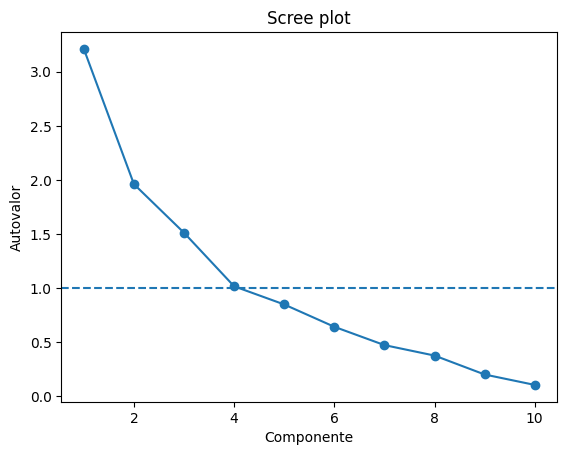

[PCA] Componentes retenidas: 4 (74.43% var. acumulada)


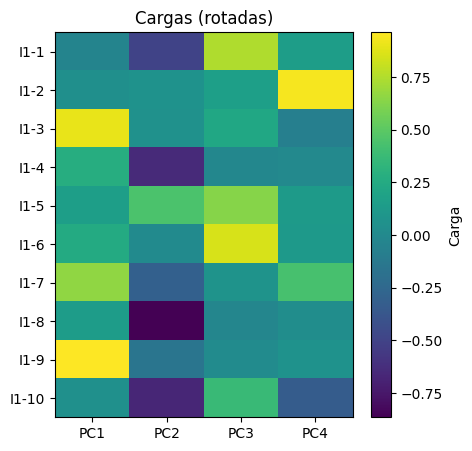


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,3.21,31.04,31.04
2,1.96,18.95,49.99
3,1.51,14.61,64.60
4,1.02,9.83,74.43



[Comunalidades]



,Comunalidad
I1-1,0.826
I1-2,0.912
I1-3,0.874
I1-4,0.492
I1-5,0.642
I1-6,0.800
I1-7,0.724
I1-8,0.770
I1-9,0.957
I1-10,0.703



[Matriz de componentes]



,PC1,PC2,PC3,PC4
I1-1,-0.039,-0.500,0.743,0.150
I1-2,0.049,0.066,0.164,0.937
I1-3,0.902,0.063,0.224,-0.078
I1-4,0.277,-0.644,-0.021,-0.001
I1-5,0.157,0.448,0.632,0.129
I1-6,0.250,0.013,0.850,0.123
I1-7,0.663,-0.307,0.073,0.431
I1-8,0.144,-0.865,-0.027,0.028
I1-9,0.963,-0.156,0.019,0.069
I1-10,0.054,-0.672,0.374,-0.330


In [26]:
info = pca_report(df_piloto, vindependiente1_cols, variance_threshold=0.80)

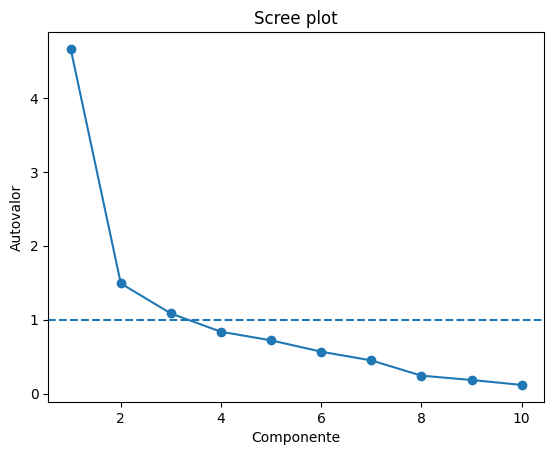

[PCA] Componentes retenidas: 4 (78.02% var. acumulada)


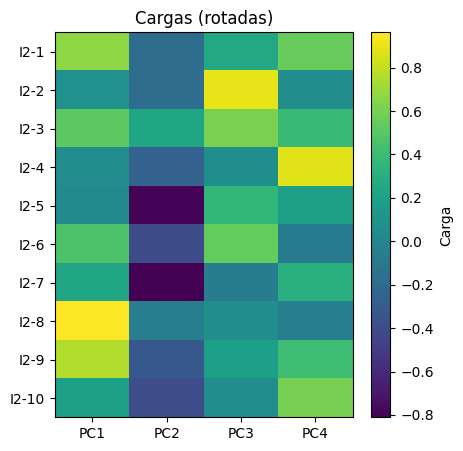


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,4.66,45.08,45.08
2,1.49,14.40,59.48
3,1.08,10.47,69.94
4,0.84,8.08,78.02



[Comunalidades]



,Comunalidad
I2-1,0.840
I2-2,0.862
I2-3,0.848
I2-4,0.845
I2-5,0.809
I2-6,0.685
I2-7,0.812
I2-8,0.937
I2-9,0.881
I2-10,0.552



[Matriz de componentes]



,PC1,PC2,PC3,PC4
I2-1,0.661,-0.178,0.257,0.552
I2-2,0.084,-0.180,0.905,0.064
I2-3,0.519,0.238,0.608,0.389
I2-4,0.059,-0.254,0.071,0.879
I2-5,0.036,-0.797,0.365,0.200
I2-6,0.468,-0.403,0.546,-0.075
I2-7,0.231,-0.811,-0.057,0.313
I2-8,0.963,-0.052,0.065,-0.049
I2-9,0.755,-0.321,0.190,0.414
I2-10,0.196,-0.389,0.061,0.599


In [27]:
 info2 = pca_report(df_piloto, vindependiente2_cols, variance_threshold=0.80)

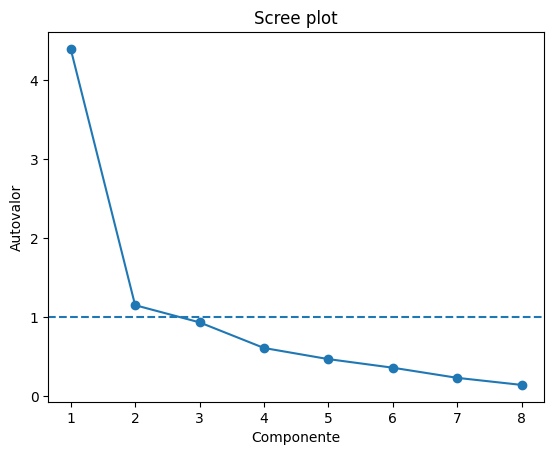

[PCA] Componentes retenidas: 3 (78.24% var. acumulada)


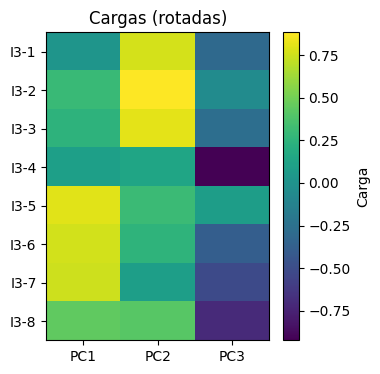


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,4.39,53.09,53.09
2,1.15,13.89,66.98
3,0.93,11.26,78.24



[Comunalidades]



,Comunalidad
I3-1,0.689
I3-2,0.877
I3-3,0.783
I3-4,0.880
I3-5,0.750
I3-6,0.790
I3-7,0.834
I3-8,0.872



[Matriz de componentes]



,PC1,PC2,PC3
I3-1,0.020,0.771,-0.308
I3-2,0.305,0.884,-0.055
I3-3,0.244,0.806,-0.270
I3-4,0.095,0.138,-0.923
I3-5,0.805,0.309,0.080
I3-6,0.761,0.250,-0.385
I3-7,0.746,0.086,-0.519
I3-8,0.445,0.416,-0.708


In [28]:
 info2 = pca_report(df_piloto, vindependiente3_cols, variance_threshold=0.80)

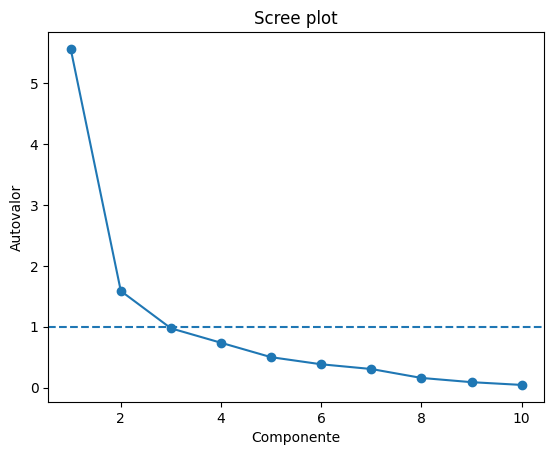

[PCA] Componentes retenidas: 3 (78.54% var. acumulada)


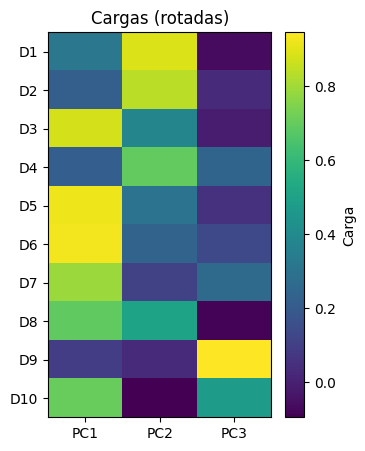


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,5.56,53.77,53.77
2,1.59,15.35,69.11
3,0.97,9.42,78.54



[Comunalidades]



,Comunalidad
D1,0.902
D2,0.750
D3,0.920
D4,0.590
D5,0.941
D6,0.934
D7,0.706
D8,0.746
D9,0.906
D10,0.729



[Matriz de componentes]



,PC1,PC2,PC3
D1,0.316,0.894,-0.064
D2,0.219,0.837,0.034
D3,0.882,0.377,-0.015
D4,0.214,0.697,0.241
D5,0.920,0.303,0.052
D6,0.927,0.238,0.135
D7,0.790,0.110,0.266
D8,0.693,0.509,-0.085
D9,0.094,0.031,0.947
D10,0.703,-0.095,0.475


In [29]:
 info2 = pca_report(df_piloto, vdependiente1_cols, variance_threshold=0.80)

In [30]:
def spearman_test(
        df: pd.DataFrame,
        col_x: str,
        col_y: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    """
    Calcula la correlación de Spearman entre dos columnas y devuelve:
      • rho                    – coeficiente de Spearman
      • se_asymptotic          – error estándar asintótico
      • t_approx               – estadístico t aproximado (rho / se)
      • pvalue                 – significancia aproximada (dos colas)
      • reject_H0              – True si p < alpha, False en caso contrario

    Parámetros
    ----------
    df : DataFrame con los datos
    col_x, col_y : nombres de las columnas a comparar
    alpha : nivel de significancia (p. ej. 0.05)
    as_ordinal :
        - False (default) → usa los valores numéricos tal cual.
        - True  → trata las columnas como ordinales;
                  si son categóricas las convierte a códigos ordenados.
    """
    # Extraer columnas y eliminar nulos simultáneos
    x = df[col_x]
    y = df[col_y]
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    # Si se solicita tratamiento ordinal, convertir a códigos ordenados
    if as_ordinal:
        if pd.api.types.is_categorical_dtype(x):
            x = x.cat.codes
        else:
            x = pd.Categorical(x, ordered=True).codes
        if pd.api.types.is_categorical_dtype(y):
            y = y.cat.codes
        else:
            y = pd.Categorical(y, ordered=True).codes

    n = len(x)
    if n < 3:
        raise ValueError("Se necesitan al menos 3 casos sin NA para Spearman.")

    # Correlación y p-value con SciPy
    rho, p = stats.spearmanr(x, y)

    # Error estándar asintótico (apx. grande-muestra)
    se = 1 / np.sqrt(n - 1)          # ≈√Var(rs)   (Kendall, 1948)

    # Estadístico t aproximado
    t_stat = rho / se                # bajo H0 ~ Normal(0,1) para n grande

    return {
        "rho": rho,
        "se_asymptotic": se,
        "t_approx": t_stat,
        "pvalue": p,
        "reject_H0": p < alpha
    }

In [31]:
df_encuesta_final = df_encuesta


In [ ]:
resultado = spearman_test(
    df=df_encuesta_final,
    col_x="Global",
    col_y="E_Global",
    alpha=0.05,          # Nivel de significancia deseado
    as_ordinal=False     # Pon True si las dos columnas son ordinales
)

print(resultado)


{'rho': np.float64(-0.047018534005683794), 'se_asymptotic': np.float64(0.11785113019775793), 't_approx': np.float64(-0.3989654908424315), 'pvalue': np.float64(0.692834469834937), 'reject_H0': np.False_}


In [ ]:
def spearman_test(
        df: pd.DataFrame,
        col_x: str,
        col_y: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    x = df[col_x]
    y = df[col_y]
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    if as_ordinal:
        x = pd.Categorical(x, ordered=True).codes
        y = pd.Categorical(y, ordered=True).codes

    n = len(x)
    if n < 3:
        raise ValueError("Se requieren al menos 3 observaciones pareadas.")

    rho, p = stats.spearmanr(x, y)
    se = 1 / np.sqrt(n - 1)
    t_stat = rho / se

    return {
        "rho": rho,
        "se_asymptotic": se,
        "t_approx": t_stat,
        "pvalue": p,
        "reject_H0": p < alpha,
        "n": n          # <= ESTA CLAVE ES LA QUE FALTABA
    }


In [ ]:
# -------------------------------------------------------------
# Pares de columnas a comparar
# -------------------------------------------------------------
alpha = 0.05      # nivel de significancia

# Versión numérica
numeric_pairs = [
    ("Global",        "A_Total"),   # Estado Nutricional vs Factor sociofamiliar
    ("Global",        "C_Total"),   # Estado Nutricional vs Estado cognitivo
    ("Global",        "E_Total")    # Estado Nutricional vs Depresión
]

# Versión de clase (ordinal)
class_pairs = [
    ("Evaluación_Clase", "A_Clase"),   # Evaluación_Clase vs Factor sociofamiliar (clase)
    ("Evaluación_Clase", "C_Clase"),   # Evaluación_Clase vs Estado cognitivo (clase)
    ("Evaluación_Clase", "E_Clase")    # Evaluación_Clase vs Depresión (clase)
]

# -------------------------------------------------------------
# Función auxiliar para imprimir resultados
# -------------------------------------------------------------
def print_result(dep, indep, res, tipo):
    decision = (
        "HAY relación y SE RECHAZA H₀"
        if res["reject_H0"] else
        "NO hay relación (no se rechaza H₀)"
    )
    print(
        f"[{tipo}] {dep} ~ {indep} | "
        f"n={res['n']:>3} | ρₛ={res['rho']:+.3f} | "
        f"p={res['pvalue']:.4f} -> {decision}"
    )

# -------------------------------------------------------------
# Ejecutar análisis
# -------------------------------------------------------------
for dep, indep in numeric_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep, alpha=alpha, as_ordinal=False)
        print_result(dep, indep, res, "Numérico")
    else:
        print(f"[Numérico] Columnas no encontradas: {dep} y/o {indep}")

print("-" * 80)

for dep, indep in class_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep, alpha=alpha, as_ordinal=True)
        print_result(dep, indep, res, "Clase (ordinal)")
    else:
        print(f"[Clase] Columnas no encontradas: {dep} y/o {indep}")

[Numérico] Global ~ A_Total | n= 73 | ρₛ=-0.476 | p=0.0000 -> HAY relación y SE RECHAZA H₀
[Numérico] Global ~ C_Total | n= 73 | ρₛ=-0.434 | p=0.0001 -> HAY relación y SE RECHAZA H₀
[Numérico] Global ~ E_Total | n= 73 | ρₛ=-0.322 | p=0.0055 -> HAY relación y SE RECHAZA H₀
--------------------------------------------------------------------------------
[Clase (ordinal)] Evaluación_Clase ~ A_Clase | n= 73 | ρₛ=-0.308 | p=0.0081 -> HAY relación y SE RECHAZA H₀
[Clase (ordinal)] Evaluación_Clase ~ C_Clase | n= 73 | ρₛ=-0.368 | p=0.0014 -> HAY relación y SE RECHAZA H₀
[Clase (ordinal)] Evaluación_Clase ~ E_Clase | n= 73 | ρₛ=-0.191 | p=0.1048 -> NO hay relación (no se rechaza H₀)


In [ ]:
# -------------------------------------------------------------
# Helper: Spearman test (numeric OR ordinal) that returns
# rho, asymptotic SE, t-statistic and p-value
# -------------------------------------------------------------
def spearman_test(
        df: pd.DataFrame,
        x_col: str,
        y_col: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    """
    Computes Spearman correlation between *x_col* and *y_col*.

    Returns
    -------
    dict
        {
            "n": sample size,
            "rho": Spearman correlation,
            "se": asymptotic standard error of rho,
            "t":  rho / se  (approx. t-statistic, df = n-2),
            "pvalue": two-tailed p-value,
            "reject_H0": bool, True if pvalue < alpha
        }
    """
    from scipy.stats import spearmanr
    import numpy as np

    # -----------------------------------------------------------------
    # Pair-wise deletion of NaNs
    # -----------------------------------------------------------------
    d = df[[x_col, y_col]].dropna()
    n = len(d)
    if n < 3:                                                       # not enough data
        return {"n": n, "rho": np.nan, "se": np.nan, "t": np.nan,
                "pvalue": np.nan, "reject_H0": False}

    x = d[x_col]
    y = d[y_col]

    # -----------------------------------------------------------------
    # If ordinal, map categories to their codes so that spearmanr works
    # -----------------------------------------------------------------
    if as_ordinal:
        if pd.api.types.is_categorical_dtype(x):
            x = x.cat.codes
        if pd.api.types.is_categorical_dtype(y):
            y = y.cat.codes

    rho, pvalue = spearmanr(x, y)

    # -----------------------------------------------------------------
    # Asymptotic standard error and t-statistic
    # -----------------------------------------------------------------
    se = np.sqrt((1.0 - rho ** 2) / (n - 1))
    t_stat = rho / se if se != 0 else np.nan

    return {
        "n": n,
        "rho": rho,
        "se": se,
        "t": t_stat,
        "pvalue": pvalue,
        "reject_H0": pvalue < alpha
    }

# -------------------------------------------------------------
# Pretty printer for one result row
# -------------------------------------------------------------
def print_result(dep: str, indep: str, res: dict, tipo: str) -> None:
    """Human-readable one-line summary of the test result."""
    decision = (
        "HAY relación y SE RECHAZA H₀"
        if res["reject_H0"] else
        "NO hay relación (no se rechaza H₀)"
    )
    print(
        f"[{tipo}] {dep} ~ {indep} | "
        f"n={res['n']:>3} | ρₛ={res['rho']:+.3f} | "
        f"SE={res['se']:.3f} | t≈{res['t']:+.2f} | "
        f"p={res['pvalue']:.4f} -> {decision}"
    )

# -------------------------------------------------------------
# Analysis loops (unchanged)
# -------------------------------------------------------------
alpha = 0.05      # significance level

# Numeric version
numeric_pairs = [
    ("Global",        "A_Total"),
    ("Global",        "C_Total"),
    ("Global",        "E_Total")
]

# Ordinal version
class_pairs = [
    ("Evaluación_Clase", "A_Clase"),
    ("Evaluación_Clase", "C_Clase"),
    ("Evaluación_Clase", "E_Clase")
]

for dep, indep in numeric_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep,
                            alpha=alpha, as_ordinal=False)
        print_result(dep, indep, res, "Numérico")
    else:
        print(f"[Numérico] Columnas no encontradas: {dep} y/o {indep}")

print("-" * 80)

for dep, indep in class_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep,
                            alpha=alpha, as_ordinal=True)
        print_result(dep, indep, res, "Clase (ordinal)")
    else:
        print(f"[Clase] Columnas no encontradas: {dep} y/o {indep}")


[Numérico] Global ~ A_Total | n= 73 | ρₛ=-0.476 | SE=0.104 | t≈-4.59 | p=0.0000 -> HAY relación y SE RECHAZA H₀
[Numérico] Global ~ C_Total | n= 73 | ρₛ=-0.434 | SE=0.106 | t≈-4.09 | p=0.0001 -> HAY relación y SE RECHAZA H₀
[Numérico] Global ~ E_Total | n= 73 | ρₛ=-0.322 | SE=0.112 | t≈-2.88 | p=0.0055 -> HAY relación y SE RECHAZA H₀
--------------------------------------------------------------------------------
[Clase (ordinal)] Evaluación_Clase ~ A_Clase | n= 73 | ρₛ=-0.308 | SE=0.112 | t≈-2.74 | p=0.0081 -> HAY relación y SE RECHAZA H₀
[Clase (ordinal)] Evaluación_Clase ~ C_Clase | n= 73 | ρₛ=-0.368 | SE=0.110 | t≈-3.36 | p=0.0014 -> HAY relación y SE RECHAZA H₀
[Clase (ordinal)] Evaluación_Clase ~ E_Clase | n= 73 | ρₛ=-0.191 | SE=0.116 | t≈-1.65 | p=0.1048 -> NO hay relación (no se rechaza H₀)


/tmp/ipython-input-98-2310748703.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-98-2310748703.py:48: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/tmp/ipython-input-98-2310748703.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-98-2310748703.py:48: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/tmp/ipython-input-98-2310748703.py:46: DeprecationWarning: is_categorical_dtype

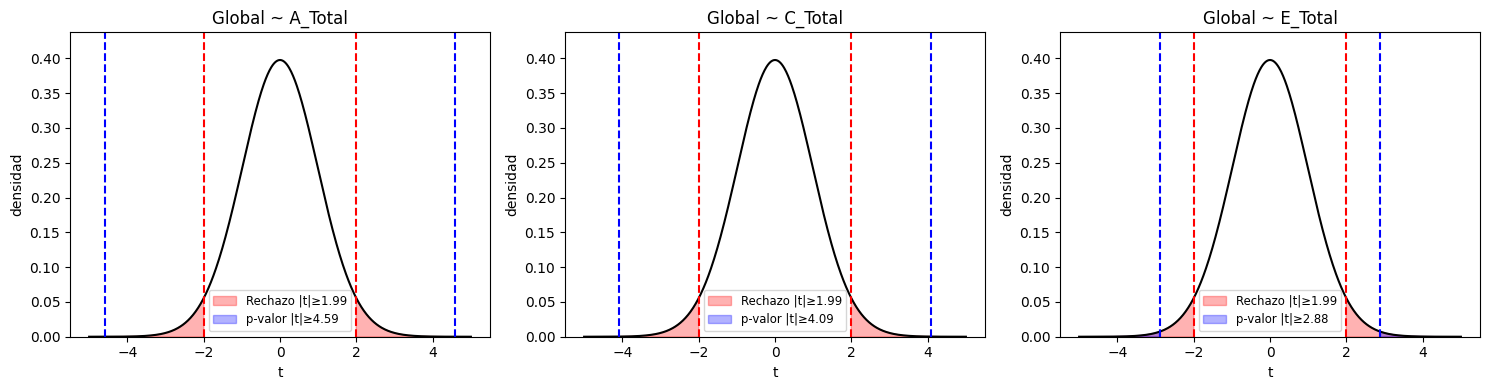

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

alpha = 0.05
numeric_pairs = [
    ("Global", "A_Total"),
    ("Global", "C_Total"),
    ("Global", "E_Total")
]

# -------------------------------------------------
# 1) Ejecutar Spearman y recolectar t-stat y df
# -------------------------------------------------
numeric_results = []
for dep, indep in numeric_pairs:
    if dep in df_encuesta_final and indep in df_encuesta_final:
        res = spearman_test(df_encuesta_final, indep, dep,
                            alpha=alpha, as_ordinal=False)
        df_grados = res["n"] - 2
        numeric_results.append((f"{dep} ~ {indep}", res["t"], df_grados))
    else:
        print(f"[Numérico] Columnas no encontradas: {dep}, {indep}")

# -------------------------------------------------
# 2) Graficar un subplot por test
# -------------------------------------------------
fig, axes = plt.subplots(1, len(numeric_results), figsize=(5*len(numeric_results), 4))
x = np.linspace(-5, 5, 600)

for ax, (label, t_stat, df_grados) in zip(axes, numeric_results):
    y = t.pdf(x, df_grados)
    ax.plot(x, y, 'k-')

    # críticos de dos colas
    t_crit = t.ppf(1 - alpha/2, df_grados)
    # sombrear región de rechazo
    ax.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit),
                    color='red', alpha=0.3, label=f"Rechazo |t|≥{t_crit:.2f}")
    # sombrear área de p-value
    ax.fill_between(x, y, where=(x <= -abs(t_stat)) | (x >= abs(t_stat)),
                    color='blue', alpha=0.3, label=f"p-valor |t|≥{abs(t_stat):.2f}")

    # líneas verticales
    ax.axvline(-t_crit, color='red', linestyle='--')
    ax.axvline( t_crit, color='red', linestyle='--')
    ax.axvline(-t_stat, color='blue', linestyle='--')
    ax.axvline( t_stat, color='blue', linestyle='--')

    ax.set_title(label)
    ax.set_ylim(0, y.max()*1.1)
    ax.set_xlabel("t")
    ax.set_ylabel("densidad")
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()


/tmp/ipython-input-98-2310748703.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-98-2310748703.py:48: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/tmp/ipython-input-98-2310748703.py:46: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(x):
/tmp/ipython-input-98-2310748703.py:48: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(y):
/tmp/ipython-input-98-2310748703.py:46: DeprecationWarning: is_categorical_dtype

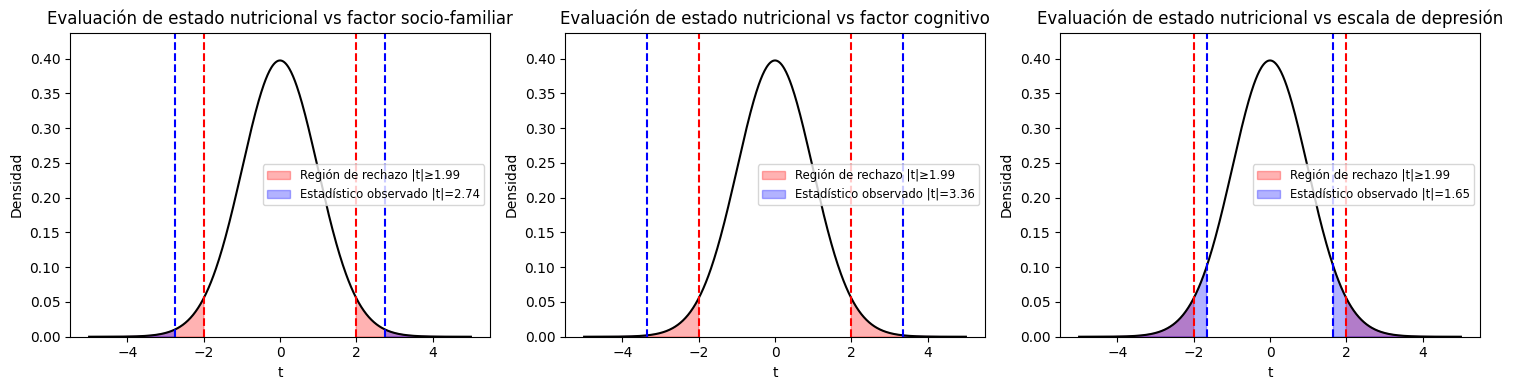

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

alpha = 0.05
class_pairs = [
    ("Evaluación_Clase", "A_Clase"),  # estado nutricional
    ("Evaluación_Clase", "C_Clase"),  # factor cognitivo
    ("Evaluación_Clase", "E_Clase")   # escala de depresión
]

# Mapeo de las variables a su etiqueta descriptiva
title_map = {
    "A_Clase": "factor socio-familiar",
    "C_Clase": "factor cognitivo",
    "E_Clase": "escala de depresión"
}

# -------------------------------------------------
# 1) Ejecutar Spearman (ordinal) y recolectar t-stat y df
# -------------------------------------------------
class_results = []
for dep, indep in class_pairs:
    if dep in df_encuesta_final and indep in df_encuesta_final:
        res = spearman_test(df_encuesta_final, indep, dep,
                            alpha=alpha, as_ordinal=True)
        df_grados = res["n"] - 2
        class_results.append((dep, indep, res["t"], df_grados))
    else:
        print(f"[Clase] Columnas no encontradas: {dep}, {indep}")

# -------------------------------------------------
# 2) Graficar un subplot por test
# -------------------------------------------------
fig, axes = plt.subplots(1, len(class_results),
                         figsize=(5*len(class_results), 4))
x = np.linspace(-5, 5, 600)

for ax, (dep, indep, t_stat, df_grados) in zip(axes, class_results):
    # densidad de la t con df moderadores
    y = t.pdf(x, df_grados)
    ax.plot(x, y, 'k-')

    # valores críticos y de estadístico
    t_crit = t.ppf(1 - alpha/2, df_grados)
    ax.fill_between(x, y, where=(x <= -t_crit) | (x >= t_crit),
                    color='red', alpha=0.3,
                    label=f"Región de rechazo |t|≥{t_crit:.2f}")
    ax.fill_between(x, y, where=(x <= -abs(t_stat)) | (x >= abs(t_stat)),
                    color='blue', alpha=0.3,
                    label=f"Estadístico observado |t|={abs(t_stat):.2f}")

    # líneas verticales
    ax.axvline(-t_crit, color='red', linestyle='--')
    ax.axvline( t_crit, color='red', linestyle='--')
    ax.axvline(-t_stat, color='blue', linestyle='--')
    ax.axvline( t_stat, color='blue', linestyle='--')

    # Título descriptivo usando el mapeo
    etiqueta_indep = title_map.get(indep, indep)
    ax.set_title(f"Evaluación de estado nutricional vs {etiqueta_indep}")

    ax.set_ylim(0, y.max() * 1.1)
    ax.set_xlabel("t")
    ax.set_ylabel("Densidad")
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()


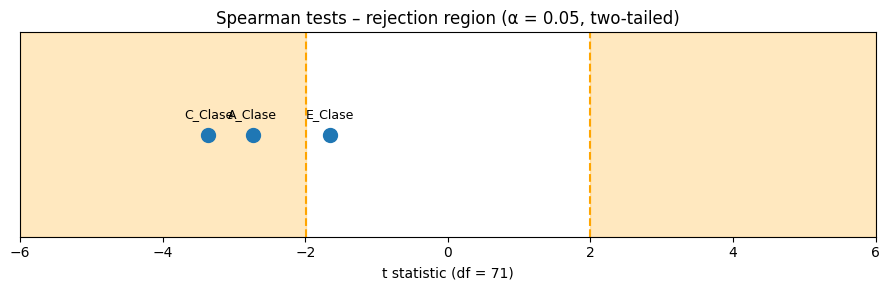

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------------------------------
# INPUT: t-statistics for each ordinal pair
# ------------------------------------------------------------------
results = {
    "A_Clase": -2.74,
    "C_Clase": -3.36,
    "E_Clase": -1.65,
}

n = 73              # tamaño de muestra
df = n - 2          # grados de libertad para t aproximada
alpha = 0.05        # nivel de significancia (dos colas)

# ------------------------------------------------------------------
# Valor crítico de t (dos colas). Requiere SciPy; si no, usa 1.99.
# ------------------------------------------------------------------
try:
    from scipy.stats import t
    tcrit = t.ppf(1 - alpha / 2, df)
except Exception:
    tcrit = 1.994  # aproximación para df≈71

# ------------------------------------------------------------------
# PLOT
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(9, 3))

# Zonas de rechazo (sombreado)
ax.axvspan(-6, -tcrit, color="orange", alpha=0.25)
ax.axvspan(tcrit,  6,  color="orange", alpha=0.25)

# Líneas límite
ax.axvline(-tcrit, ls="--", color="orange")
ax.axvline(tcrit,  ls="--", color="orange")

# Puntos de cada contraste
x_vals = list(results.values())
labels = list(results.keys())
ax.scatter(x_vals, np.zeros_like(x_vals), s=100, zorder=3)

# Anotar cada punto
for x, label in zip(x_vals, labels):
    ax.annotate(label, (x, 0), xytext=(0, 12), textcoords="offset points",
                ha="center", fontsize=9)

# Formato
ax.set_xlim(-6, 6)
ax.set_ylim(-1, 1)
ax.set_yticks([])
ax.set_xlabel(f"t statistic (df = {df})")
ax.set_title(f"Spearman tests – rejection region (α = {alpha}, two-tailed)")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import shapiro




# 3. Variables a evaluar
variables = ['Global', 'A_Total', 'C_Total', 'E_Total']

# 4. Ejecuta Shapiro–Wilk
results = []
for var in variables:
    datos = df_encuesta_final[var].dropna()
    W, p = shapiro(datos)
    results.append({
        'variable': var,
        'W_stat': round(W, 4),
        'p_value': round(p, 4),
        'normal? (p > 0.05)': p > 0.05
    })

# 5. Muestra la tabla
print(pd.DataFrame(results))


  variable  W_stat  p_value  normal? (p > 0.05)
0   Global  0.9756   0.1672                True
1  A_Total  0.9447   0.0030               False
2  C_Total  0.9368   0.0012               False
3  E_Total  0.9466   0.0038               False
